# Learning Uncertainty Sets

In [2]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

### Example 4: Portfolio management


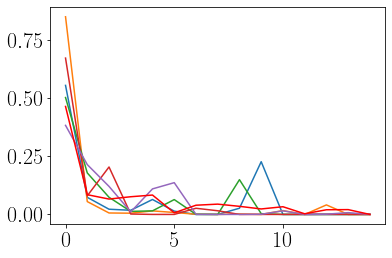

In [28]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
    0.1 + i*0.05*scale, np.sqrt((0.02**2+(i*0.08)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

def loss(t,x,p,alpha, data,mu=1000,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    sums += torch.sum(torch.maximum(-data@x - t - alpha, torch.tensor(0.,requires_grad = True)))
    totsum += torch.sum(torch.where(torch.maximum(-data@x - t - alpha, torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return t + 0.05*torch.norm(x-p,1) + torch.tensor(l)*(sums - torch.tensor(target)) + torch.tensor(mu/2)*(sums - torch.tensor(target))**2, t + 0.05*torch.norm(x-p,1), totsum/Nsample, sums.detach().numpy()

n = 15
N = 500
seed = 15
np.random.seed(seed)
data = data_modes(1000,n,[1,2,3],seed = seed)
dist = (np.array([250,100,60,50,40,30,30,20,20,15,10,10,10,10,10,10])/100)[:n]
#dist = np.ones(n)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = np.reshape(np.random.dirichlet(dist,1),(n,))

for i in range(num_scenarios):
  plt.plot(scenarios[i][0])

x = cp.Variable(n)
t = cp.Variable()
p = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t)

constraints = [-data@x <= t,cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
plt.plot(x.value, color = "red")

In [42]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()
p = cp.Parameter(n)
p.value = scenarios[0][0]
# p1.value = scenarios[0][1]
objective = cp.Minimize(t + 0.05*cp.norm(x - p,1))

constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

prob = lropt.RobustProblem(objective, constraints)
target = -0.01
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False, init_mu = 5, init_lam = 0, target_cvar = target, init_alpha = 0., mu_multiplier = 1.01, test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, max_inner_iter = 1)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result3 = prob.train(eps = True, lr = 0.0001, step=1600, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, init_mu = 5, init_lam = 0,  target_cvar = target, init_alpha =0.,mu_multiplier = 1.01,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = result3.A, init_b = result3.b, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01, 3, 40), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0.,test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

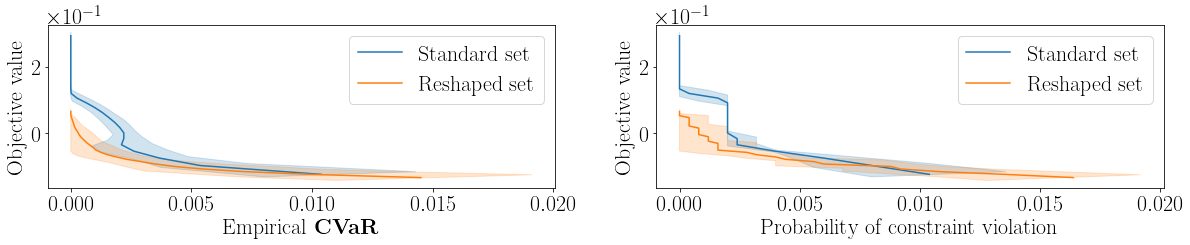

In [48]:
plot_tradeoff(dfgrid,dfgrid2,"Port",ind_1 = (12,100), ind_2 = (10,100))

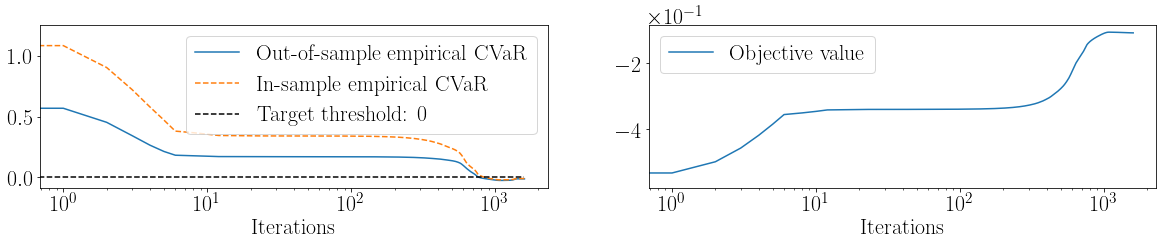

In [49]:
plot_iters(df1,"Port",logscale = 1)